#  Analytics Experience - Group Project - MSCI:6040 

By Group 2 (Chris Wagner, Palden Williams, Tarun Mandava  - Data Scientists) 
- September, 2020                                                             

Objective - This project is an exercise in using natural language processing to determine if social media posts meet a pre-specified criterion.  In this case, the test is to determine which social media posts truly reflect information tied to a natural disaster.  For this exercise, we are working with a test dataset of Twitter posts that have been manually reviewed from Kraggle.

Data source:  Real or Not?  NLP with Disaster Tweets dataset from Kaggle

### Spacy Library generated Vectorization with SVC Model

This sample is looking at using the Spacy Library with its precompiled vectors to generate a Glove-like vectorization for our model.  Again, we'll use the Support Vector Classification out of the SVM library in SKLearn for the predictive modelling.

###### Acknowledgements/Sources

https://faculty.ai/blog/glove/<br>
https://nlp.stanford.edu/projects/glove/


#### Library Imports

In [42]:
import spacy
import pandas as pd
import matplotlib.pyplot as mplt
import seaborn as sn
import matplotlib.pyplot as plt                     
import numpy as np           
import plotly.offline as plyo

In [43]:
import random
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
from collections import defaultdict
import string

from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from tqdm import tqdm

#### Read in the Kaggle datasets

In [44]:
sample_submission_data = pd.read_csv("Data/OriginalData/sample_submission.csv")
test_data = pd.read_csv("Data/OriginalData/test.csv")
train_data = pd.read_csv("Data/OriginalData/train.csv")

#### Data Cleaning

The following functions will be used to remove punctuation, html, URL's, emoji's and force the data to lowercase from the incomming text data

In [45]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)



def  clean_text(df, text):
    df[text] = df[text].str.lower()
    df[text] = df[text].apply(lambda x: remove_emoji(x))
    df[text] = df[text].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

In [46]:
#clean the text form the input files
test_data = clean_text(test_data, "text")
train_data = clean_text(train_data, "text")

#### Vectorizing the data

The following code will create a class that will inherit from the sklearn BaseEstimator and TransformerMixin libraries.  It overrides the fit and transform functions to utilize the internal nlp object for creating the model vectors.

In [47]:
# code provided by faculty.ai at https://faculty.ai/blog/glove/

import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

class GloveVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="en_core_web_md"):
        self._nlp = spacy.load(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.concatenate(
            [self._nlp(doc).vector.reshape(1, -1) for doc in X]
        )

In order to identify the contents, we created specific variables for the X and Y training values, and an X_Test used to pull the return values to return to Kaggle for scoring.

In [48]:
X=train_data["text"]
y=train_data["target"]
X_Test = test_data["text"]

#### Model the training set of Twitter data

A pipeline was used to create an instance of the GloveVectorizer class as well as a new SVC model.  After the model is created, it is fit with the X and Y values from the training set above.

In [49]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn import svm

In [50]:
g = GloveVectorizer()
svm = svm.SVC()

pline = make_pipeline(g,svm)

pline.fit(X,y)

C:\Users\chris\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



Pipeline(memory=None,
         steps=[('glovevectorizer', GloveVectorizer(model_name=None)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Model has been created, let's review the score with the training set:

In [51]:
s = pline.score(X,y)

In [53]:
s

0.8418494680152371

Now we'll pull the sample submission dataset, score it against our model, and retrun the value to Kaggle for evaluation

In [54]:
sub = pd.read_csv('Data/OriginalData/sample_submission.csv')

In [55]:
sub.target = pline.predict(X_Test)
sub.to_csv("spacy_svm_glove_submission.csv",index=False)

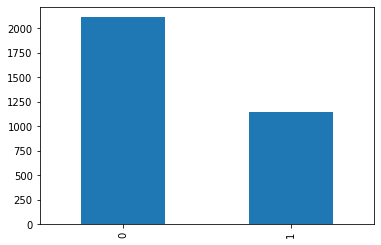

In [56]:
sub.target.value_counts().plot.bar();

For a further example, we pulled a sample of 100 tweets from Twitter with the keyword "wildfires".  Let's apply that to the model to see how it performed as well.

In [57]:
tweets = pd.read_csv("recent_tweets.csv")
tweets = clean_text(tweets,"Text")

t_test = tweets["Text"]

In [58]:
tweets["Target"] = pline.predict(t_test)

In [59]:
tweets.head()

,CreatedOn,ID,Text,Target
0,2020-10-19 03:54:00,1318037658682019840,theres a wildfire in the high country and all ...,1
1,2020-10-19 03:50:40,1318036820207181825,sunday night update issues wildfire weather w...,1
2,2020-10-19 03:50:27,1318036764590628864,video of homes on firecalwoodfirecolorado cofi...,0
3,2020-10-19 03:50:24,1318036752657862661,exactly the timing of the reversal on the wi...,1
4,2020-10-19 03:49:30,1318036526740180992,active fire detected in pium state of tocanti...,1


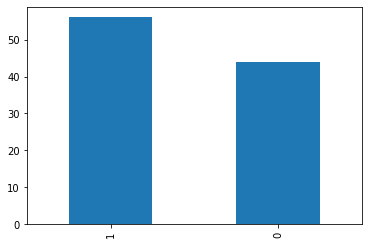

In [60]:
tweets.Target.value_counts().plot.bar();

In [61]:
tweets.to_csv("recent_tweets_scored.csv",index=False)